In [1]:
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

## Загружаем данные из файла

In [2]:
data=pd.read_csv('events (3).csv')
pd.set_option('display.max_rows', 10) # None
pd.set_option('display.max_columns', 50) # None
data.head()

,app_version_name,event_name,event_json,event_datetime
0,1.4.3,cdn_config_categories_download_start,"{""balance"":""340"",""days_in_game"":""1"",""PuzzleCom...",2022-05-08 17:14:24
1,1.4.3,game_puzzle_onscreen,"{""puzzle_id"":""38"",""Order_number"":""11"",""puzzle_...",2022-05-08 17:14:24
2,1.4.1,game_puzzle_pause,"{""puzzle_id"":""13"",""Order_number"":""13"",""categor...",2022-05-08 18:56:32
3,1.4.3,game_puzzle_pause,"{""puzzle_id"":""38"",""Order_number"":""11"",""categor...",2022-05-08 17:14:24
4,1.4.1,game_puzzle_placed,"{""puzzle_id"":""13"",""Order_number"":""13"",""PuzzleS...",2022-05-08 18:55:14


## Оставляем в датафрейме только event_name связанные с пазлами:  
'show_image'  
'game_puzzle_start'  
'game_puzzle_complete'  
'game_puzzle_quit'  
'game_puzzle_concat'  
'game_puzzle_receive'  
'game_puzzle_click'  
'game_puzzle_start_continue'  
'game_puzze_onscreen'  
## В jsone осталяем нужное и делаем один датафрейм

In [3]:
data=data[data['event_name'].isin(\
    ['show_image', 'game_puzzle_start', 'game_puzzle_complete', 'game_puzzle_quit', 'game_puzzle_concat', 'game_puzzle_receive', 'game_puzzle_click', 'game_puzzle_start_continue', 'game_puzze_onscreen']\
        )].reset_index(drop=True)

# развернем json
data_json = pd.json_normalize(list(map(json.loads, data.event_json)))

# сформируем фрейм с которым будем работать
data_work = data[['event_name', 'event_datetime', 'app_version_name']]

# добавим столбец с единым идентификатором пазла
data_work['cat_puzzle_id'] = data_json.category_id.astype(str) + '_' + data_json.puzzle_id.astype(str)

# сконкатим фреймы data и json
data_work = pd.concat([data_work, data_json[[\
    'category_id','place','days_in_game','place','PuzzleComplete','PuzzleStart','Rotate','Difficulty','completed','background','Progress','Continue','started','available','Percent','Concat','Placed']\
        ]], axis=1)

## Датафрейм, со всем необходимым

In [4]:
data_work.head()

,event_name,event_datetime,app_version_name,cat_puzzle_id,category_id,place,days_in_game,place,PuzzleComplete,PuzzleStart,Rotate,Difficulty,completed,background,Progress,Continue,started,available,Percent,Concat,Placed
0,game_puzzle_click,2022-05-09 00:31:12,1.4.1,4_13,4,daily,3,daily,3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,game_puzzle_click,2022-05-09 00:41:00,1.4.1,32_1,32,inprogress,3,inprogress,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,game_puzzle_click,2022-05-09 01:43:02,1.4.3,34_38,34,daily,1,daily,41,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,game_puzzle_click,2022-05-09 02:27:31,1.4.3,21_60,21,inprogress,2,inprogress,45,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,game_puzzle_click,2022-05-09 02:35:17,1.4.3,4_31,4,inprogress,2,inprogress,46,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Оставим в нашем датафрейме только события в которых place == daily, catalog  
### будем считать что так мы выделим релевантные данные для оценки конверсии/привлекательности пазлов

In [5]:
data_work = data_work[data_json['place'].isin(['daily', 'catalog'])]
data_work.head(3)

,event_name,event_datetime,app_version_name,cat_puzzle_id,category_id,place,days_in_game,place,PuzzleComplete,PuzzleStart,Rotate,Difficulty,completed,background,Progress,Continue,started,available,Percent,Concat,Placed
0,game_puzzle_click,2022-05-09 00:31:12,1.4.1,4_13,4,daily,3,daily,3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,game_puzzle_click,2022-05-09 01:43:02,1.4.3,34_38,34,daily,1,daily,41,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,game_puzzle_click,2022-05-09 03:15:38,1.4.3,7_41,7,daily,2,daily,47,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Опишем функцию которая посчитает для переданого датафрейма:
Показы  
Старты  
Комплиты  
Конверсию показов в старты  
Конверсию стартов в комплиты  
Конверсию стартов в quitы  
__Все значения считаются только для событий из daily&catalog, для не собранных ранее пазлов (completed!="1") и заданного набора Difficulty__

In [6]:
def conversion_count_simply(data, mask, difficulty=["36"]):
    # показы
    show_image = data.query('event_name=="show_image" and completed!="1"').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    show_image.rename(columns={'event_name':'shows_'+mask}, inplace=True)
    show_image.reset_index(inplace=True)

    # старты пазлов со сложностью difficulty
    game_puzzle_start = data[data['Difficulty'].isin(difficulty)].query('event_name=="game_puzzle_start"').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    game_puzzle_start.rename(columns={'event_name':'starts_'+mask}, inplace=True)
    game_puzzle_start.reset_index(inplace=True)

    # комплиты пазлов со сложнотью difficulty
    game_puzzle_complete = data[data['Difficulty'].isin(difficulty)].query('event_name=="game_puzzle_complete"').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    game_puzzle_complete.rename(columns={'event_name':'complets_'+mask}, inplace=True)
    game_puzzle_complete.reset_index(inplace=True)

    # quitы пазлов со сложностью difficulty
    game_puzzle_quit = data[data['Difficulty'].isin(difficulty)].query('event_name=="game_puzzle_quit"').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    game_puzzle_quit.rename(columns={'event_name':'quits_'+mask}, inplace=True)
    game_puzzle_quit.reset_index(inplace=True)

    # удалим странный пазл
    show_image = show_image.query('cat_puzzle_id != "23_38"').reset_index(drop=True)

    data_count_all = show_image.merge(game_puzzle_start, how='left').merge(game_puzzle_complete, how='left').merge(game_puzzle_quit, how='left')

    data_count_all = data_count_all.fillna(0)

    data_count_all['conv_to_start_'+mask] = round (data_count_all['starts_'+mask] / data_count_all['shows_'+mask] * 100, 2)
    data_count_all['conv_to_complete_'+mask] = round (data_count_all['complets_'+mask] / data_count_all['starts_'+mask] * 100, 2)
    data_count_all['conv_to_quit_'+mask] = round (data_count_all['quits_'+mask] / data_count_all['starts_'+mask] * 100, 2)
    data_count_all = data_count_all.fillna(0)
    data_count_all = data_count_all.replace(np.inf, 0)
    return data_count_all


## Расчитаем конверсии по всей выборке и по версиям приложения (для всех Difficulty)

In [7]:
dif_ty=['36','49','144','256','441']
#dif_ty=['36']
conversion_table_simply = pd.concat([conversion_count_simply(data_work, 'full', dif_ty),\
    conversion_count_simply(data_work.query('app_version_name == "1.3.33"'), '1.3.33', dif_ty).iloc[:,2:10],\
        conversion_count_simply(data_work.query('app_version_name == "1.4"'), '1.4', dif_ty).iloc[:,2:10],\
            conversion_count_simply(data_work.query('app_version_name == "1.4.1"'), '1.4.1', dif_ty).iloc[:,2:10],\
                conversion_count_simply(data_work.query('app_version_name == "1.4.3"'), '1.4.3', dif_ty).iloc[:,2:10]], axis=1)

In [8]:
# Таблица со всеми конверсиями и цифрами strats, complets  и quits
conversion_table_simply.sort_values('shows_full', ascending=False).head(5)

,cat_puzzle_id,category_id,shows_full,starts_full,complets_full,quits_full,conv_to_start_full,conv_to_complete_full,conv_to_quit_full,shows_1.3.33,starts_1.3.33,complets_1.3.33,quits_1.3.33,conv_to_start_1.3.33,conv_to_complete_1.3.33,conv_to_quit_1.3.33,shows_1.4,starts_1.4,complets_1.4,quits_1.4,conv_to_start_1.4,conv_to_complete_1.4,conv_to_quit_1.4,shows_1.4.1,starts_1.4.1,complets_1.4.1,quits_1.4.1,conv_to_start_1.4.1,conv_to_complete_1.4.1,conv_to_quit_1.4.1,shows_1.4.3,starts_1.4.3,complets_1.4.3,quits_1.4.3,conv_to_start_1.4.3,conv_to_complete_1.4.3,conv_to_quit_1.4.3
371,1_33,1,82969,4615,3114,502.0,5.56,67.48,10.88,2.0,1.0,1.0,0.0,50.00,100.0,0.0,30009,1484,1087,171.0,4.95,73.25,11.52,18487,1150.0,716.0,135.0,6.22,62.26,11.74,9777,508.0,317.0,62.0,5.20,62.40,12.20
873,31_8,31,78129,4241,2782,493.0,5.43,65.60,11.62,23.0,2.0,1.0,0.0,8.70,50.0,0.0,31869,1515,1057,189.0,4.75,69.77,12.48,19538,1217.0,738.0,165.0,6.23,60.64,13.56,118,1.0,0.0,0.0,0.85,0.00,0.00
964,34_1,34,75374,3903,2457,545.0,5.18,62.95,13.96,13.0,1.0,1.0,0.0,7.69,100.0,0.0,30304,1336,916,204.0,4.41,68.56,15.27,19032,1104.0,645.0,157.0,5.80,58.42,14.22,140,7.0,5.0,1.0,5.00,71.43,14.29
496,21_3,21,69279,4462,2748,618.0,6.44,61.59,13.85,51.0,1.0,1.0,0.0,1.96,100.0,0.0,27730,1687,1111,248.0,6.08,65.86,14.70,17696,1264.0,705.0,205.0,7.14,55.78,16.22,121,3.0,3.0,0.0,2.48,100.00,0.00
815,31_27,31,11325,445,292,36.0,3.93,65.62,8.09,4.0,1.0,1.0,0.0,25.00,100.0,0.0,152,20,16,1.0,13.16,80.00,5.00,77,15.0,9.0,1.0,19.48,60.00,6.67,11001,390.0,252.0,33.0,3.55,64.62,8.46


## Сведем в таблицу средние конверсий по версиям (+full)

In [9]:
conversion_only = conversion_table_simply[['conv_to_start_full','conv_to_complete_full','conv_to_quit_full',\
    'conv_to_start_1.3.33','conv_to_complete_1.3.33','conv_to_quit_1.3.33',\
        'conv_to_start_1.4','conv_to_complete_1.4','conv_to_quit_1.4',\
           'conv_to_start_1.4.1','conv_to_complete_1.4.1','conv_to_quit_1.4.1',\
               'conv_to_start_1.4.3','conv_to_complete_1.4.3','conv_to_quit_1.4.3']]

In [10]:
conversion_only = conversion_table_simply[['conv_to_start_full','conv_to_complete_full','conv_to_quit_full',\
    'conv_to_start_1.3.33','conv_to_complete_1.3.33','conv_to_quit_1.3.33',\
        'conv_to_start_1.4','conv_to_complete_1.4','conv_to_quit_1.4',\
           'conv_to_start_1.4.1','conv_to_complete_1.4.1','conv_to_quit_1.4.1',\
               'conv_to_start_1.4.3','conv_to_complete_1.4.3','conv_to_quit_1.4.3']]

conv_matrix_simply = pd.DataFrame(columns=['full', 'v1.3.33', 'v1.4', 'v1.4.1', 'v1.4.3'], index = ['conv_to_start', 'conv_to_complete', 'conv_to_quit'])
counter = 0
for i in range(5):
    x= []
    for j in range(3):
        x.append(round(conversion_only.iloc[:,counter].mean(),2))
        counter+=1
    conv_matrix_simply.iloc[:,i] = x
conv_matrix_simply

,full,v1.3.33,v1.4,v1.4.1,v1.4.3
conv_to_start,6.31,7.37,5.92,7.30,4.84
conv_to_complete,72.09,26.98,75.67,67.73,71.67
conv_to_quit,9.35,0.90,10.30,10.43,7.03


## Оценим распределение конверсии conv_to_complete по всем наблюдениям(full)

<AxesSubplot:>

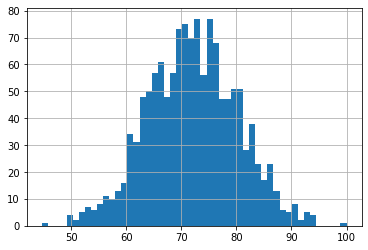

In [11]:
conversion_table_simply.conv_to_complete_full.hist(bins=50)

In [12]:
# Полная конверсия распределена нормально.
import scipy
stat, p = scipy.stats.shapiro(list(conversion_table_simply.conv_to_complete_full)) # тест Шапиро-Уилкa
print('Statistics=%.3f, p-value=%.5f' % (stat, p))

Statistics=0.999, p-value=0.84999


### Конверсия conv_to_complete по всем наблюдениям(full) распределена нормально.

In [13]:
mean, sigma = np.mean(list(conversion_table_simply.conv_to_complete_full)), np.std(list(conversion_table_simply.conv_to_complete_full))
conf_int = stats.norm.interval(0.95, loc=mean, scale=sigma)

print('Среднее для конверсии start to complete ', round(conversion_table_simply.conv_to_complete_full.mean(),2))
print('Медиана для конверсии start to complete ', round(conversion_table_simply.conv_to_complete_full.median(),2))
print('Дисперсия для конверсии start to complete ', round(np.var(conversion_table_simply.conv_to_complete_full),2))
print('Стандартное отклонение для конверсии start to complete ', round(np.std(conversion_table_simply.conv_to_complete_full),2))
print('95% доверительный интервал для конверсии --/-- ', list(np.round(conf_int,2)))

Среднее для конверсии start to complete  72.09
Медиана для конверсии start to complete  72.06
Дисперсия для конверсии start to complete  65.91
Стандартное отклонение для конверсии start to complete  8.12
95% доверительный интервал для конверсии --/--  [56.18, 88.01]


## Посмотрим на коверсии первых стартов (Difficulty = 36) и последующих стартов (_start+plus) по версиям приложения.

In [14]:
#dif_ty=['36','49','144','256','441']
dif_ty=['36']

In [15]:
# Преобразуем типы данных
data_work['PuzzleComplete'] =pd.to_numeric(data_work.PuzzleComplete)
data_work['PuzzleStart'] =pd.to_numeric(data_work.PuzzleStart)

In [16]:
# выделим из датафрейма события связанные с первыми стартами и первыми комплитами
# PuzzleComplete == 1 потому что зачисление собранного пазла происходит "мгновенно"
# PuzzleStart == 0 потому что зачисление старта пазла происходит с задержкой на 1 ед.
#data_firs_start = pd.concat([data_work[data_work['event_name'] == 'game_puzzle_complete'].query('PuzzleComplete == 1'), data_work[data_work['event_name'] == 'game_puzzle_start'].query('PuzzleStart == 0')], ignore_index=True)
data_firs_start = data_work.query('PuzzleComplete == 1 or PuzzleStart == 0')



#data_firs_start_plus = pd.concat([data_work.query('PuzzleComplete >=0'), data_work.query('PuzzleStart >=1')], ignore_index=True)
data_firs_start_plus =  data_work.query('PuzzleStart >=1')

## Функция расчета первых конверсий

In [17]:
def first_conversion(data_work, mask ,difficulty=['36']):

     show_image = pd.DataFrame(data_work.query('event_name=="show_image" and completed!="1" and PuzzleStart == 0').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1])
     show_image.rename(columns={'event_name':'shows_'+mask}, inplace=True)
     show_image.reset_index(inplace=True)

     data_work = data_work[data_work['Difficulty'].isin(difficulty)]

     game_puzzle_complete = pd.DataFrame(data_work[data_work['event_name'] == 'game_puzzle_complete'].query('PuzzleComplete == 1').groupby(by=['cat_puzzle_id', 'category_id']).count()['event_datetime'])
     game_puzzle_complete.rename(columns={'event_datetime':'complets_'+mask}, inplace=True)
     game_puzzle_complete.reset_index(inplace=True)

     game_puzzle_start = pd.DataFrame(data_work[data_work['event_name'] == 'game_puzzle_start'].query('PuzzleStart == 0').groupby(by=['cat_puzzle_id', 'category_id']).count()['event_datetime'])
     game_puzzle_start.rename(columns={'event_datetime':'starts_'+mask}, inplace=True)
     game_puzzle_start.reset_index(inplace=True)

     game_puzzle_quit = pd.DataFrame(data_work[data_work['event_name'] == 'game_puzzle_quit'].query('PuzzleStart == 1').groupby(by=['cat_puzzle_id', 'category_id']).count()['event_datetime'])
     game_puzzle_quit.rename(columns={'event_datetime':'quits_'+mask}, inplace=True)
     game_puzzle_quit.reset_index(inplace=True)

     # удалим странный пазл
     show_image = show_image.query('cat_puzzle_id != "23_38"').reset_index(drop=True)

     data_count_all = show_image.merge(game_puzzle_start, how='left').merge(game_puzzle_complete, how='left').merge(game_puzzle_quit, how='left')

     data_count_all = data_count_all.fillna(0)

     data_count_all['conv_to_start_'+mask] = round (data_count_all['starts_'+mask] / data_count_all['shows_'+mask] * 100, 2)
     data_count_all['conv_to_complete_'+mask] = round (data_count_all['complets_'+mask] / data_count_all['starts_'+mask] * 100, 2)
     data_count_all['conv_to_quit_'+mask] = round (data_count_all['quits_'+mask] / data_count_all['starts_'+mask] * 100, 2)
     data_count_all = data_count_all.fillna(0)
     data_count_all = data_count_all.replace(np.inf, 0)
     return data_count_all

## Функция расчет первых ПЛЮС конверсий

In [18]:
def first_conversion_plus(data_work, mask ,difficulty=['36']):

     show_image = pd.DataFrame(data_work.query('event_name=="show_image" and completed!="1" and PuzzleStart >0').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1])
     show_image.rename(columns={'event_name':'shows_'+mask}, inplace=True)
     show_image.reset_index(inplace=True)

     data_work = data_work[data_work['Difficulty'].isin(difficulty)]

     game_puzzle_complete = pd.DataFrame(data_work[data_work['event_name'] == 'game_puzzle_complete'].query('PuzzleComplete > 1').groupby(by=['cat_puzzle_id', 'category_id']).count()['event_datetime'])
     game_puzzle_complete.rename(columns={'event_datetime':'complets_'+mask}, inplace=True)
     game_puzzle_complete.reset_index(inplace=True)

     game_puzzle_start = pd.DataFrame(data_work[data_work['event_name'] == 'game_puzzle_start'].query('PuzzleStart > 0').groupby(by=['cat_puzzle_id', 'category_id']).count()['event_datetime'])
     game_puzzle_start.rename(columns={'event_datetime':'starts_'+mask}, inplace=True)
     game_puzzle_start.reset_index(inplace=True)

     game_puzzle_quit = pd.DataFrame(data_work[data_work['event_name'] == 'game_puzzle_quit'].query('PuzzleStart > 1').groupby(by=['cat_puzzle_id', 'category_id']).count()['event_datetime'])
     game_puzzle_quit.rename(columns={'event_datetime':'quits_'+mask}, inplace=True)
     game_puzzle_quit.reset_index(inplace=True)

     # удалим странный пазл
     show_image = show_image.query('cat_puzzle_id != "23_38"').reset_index(drop=True)

     data_count_all = show_image.merge(game_puzzle_start, how='left').merge(game_puzzle_complete, how='left').merge(game_puzzle_quit, how='left')

     data_count_all = data_count_all.fillna(0)

     data_count_all['conv_to_start_'+mask] = round (data_count_all['starts_'+mask] / data_count_all['shows_'+mask] * 100, 2)
     data_count_all['conv_to_complete_'+mask] = round (data_count_all['complets_'+mask] / data_count_all['starts_'+mask] * 100, 2)
     data_count_all['conv_to_quit_'+mask] = round (data_count_all['quits_'+mask] / data_count_all['starts_'+mask] * 100, 2)
     data_count_all = data_count_all.fillna(0)
     data_count_all = data_count_all.replace(np.inf, 0)
     return data_count_all

## Таблица конверсий первых стартов по версиям приложения (Difficulty = 36)

In [19]:
#dif_ty=['36','49','144','256','441']
dif_ty=['36']
conversion_table_first = pd.concat([first_conversion(data_firs_start, 'full', dif_ty),\
    first_conversion(data_firs_start.query('app_version_name == "1.3.33"'), '1.3.33', dif_ty).iloc[:,2:10],\
        first_conversion(data_firs_start.query('app_version_name == "1.4"'), '1.4', dif_ty).iloc[:,2:10],\
            first_conversion(data_firs_start.query('app_version_name == "1.4.1"'), '1.4.1', dif_ty).iloc[:,2:10],\
                first_conversion(data_firs_start.query('app_version_name == "1.4.3"'), '1.4.3', dif_ty).iloc[:,2:10]], axis=1)
conversion_table_first.sort_values('shows_full', ascending=False).head()

,cat_puzzle_id,category_id,shows_full,starts_full,complets_full,quits_full,conv_to_start_full,conv_to_complete_full,conv_to_quit_full,shows_1.3.33,starts_1.3.33,complets_1.3.33,quits_1.3.33,conv_to_start_1.3.33,conv_to_complete_1.3.33,conv_to_quit_1.3.33,shows_1.4,starts_1.4,complets_1.4,quits_1.4,conv_to_start_1.4,conv_to_complete_1.4,conv_to_quit_1.4,shows_1.4.1,starts_1.4.1,complets_1.4.1,quits_1.4.1,conv_to_start_1.4.1,conv_to_complete_1.4.1,conv_to_quit_1.4.1,shows_1.4.3,starts_1.4.3,complets_1.4.3,quits_1.4.3,conv_to_start_1.4.3,conv_to_complete_1.4.3,conv_to_quit_1.4.3
371,1_33,1,21774,589.0,356.0,0.0,2.71,60.44,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6162,151.0,97.0,0.0,2.45,64.24,0.0,5857,167.0,86.0,0.0,2.85,51.50,0.0,2617.0,105.0,60.0,0.0,4.01,57.14,0.0
873,31_8,31,20277,885.0,580.0,0.0,4.36,65.54,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6498,282.0,204.0,0.0,4.34,72.34,0.0,6238,293.0,168.0,0.0,4.70,57.34,0.0,2.0,0.0,0.0,0.0,0.00,0.00,0.0
964,34_1,34,19783,806.0,489.0,0.0,4.07,60.67,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6353,250.0,163.0,0.0,3.94,65.20,0.0,6058,257.0,126.0,0.0,4.24,49.03,0.0,11.0,0.0,0.0,0.0,0.00,0.00,0.0
496,21_3,21,18718,1261.0,703.0,0.0,6.74,55.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6044,465.0,282.0,0.0,7.69,60.65,0.0,5706,389.0,191.0,0.0,6.82,49.10,0.0,6.0,0.0,0.0,0.0,0.00,0.00,0.0
815,31_27,31,2830,41.0,26.0,0.0,1.45,63.41,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,21,1.0,1.0,0.0,4.76,100.00,0.0,26,4.0,3.0,0.0,15.38,75.00,0.0,3.0,0.0,0.0,0.0,0.00,0.00,0.0


## Таблица конверсий первых ПЛЮС стартов по версиям приложения (Difficulty = 36)

In [20]:
conversion_table_first_plus = pd.concat([first_conversion_plus(data_firs_start_plus, 'full', dif_ty),\
    first_conversion_plus(data_firs_start_plus.query('app_version_name == "1.3.33"'), '1.3.33', dif_ty).iloc[:,2:10],\
        first_conversion_plus(data_firs_start_plus.query('app_version_name == "1.4"'), '1.4', dif_ty).iloc[:,2:10],\
            first_conversion_plus(data_firs_start_plus.query('app_version_name == "1.4.1"'), '1.4.1', dif_ty).iloc[:,2:10],\
                first_conversion_plus(data_firs_start_plus.query('app_version_name == "1.4.3"'), '1.4.3', dif_ty).iloc[:,2:10]], axis=1)
conversion_table_first_plus.sort_values('shows_full', ascending=False).head()

,cat_puzzle_id,category_id,shows_full,starts_full,complets_full,quits_full,conv_to_start_full,conv_to_complete_full,conv_to_quit_full,shows_1.3.33,starts_1.3.33,complets_1.3.33,quits_1.3.33,conv_to_start_1.3.33,conv_to_complete_1.3.33,conv_to_quit_1.3.33,shows_1.4,starts_1.4,complets_1.4,quits_1.4,conv_to_start_1.4,conv_to_complete_1.4,conv_to_quit_1.4,shows_1.4.1,starts_1.4.1,complets_1.4.1,quits_1.4.1,conv_to_start_1.4.1,conv_to_complete_1.4.1,conv_to_quit_1.4.1,shows_1.4.3,starts_1.4.3,complets_1.4.3,quits_1.4.3,conv_to_start_1.4.3,conv_to_complete_1.4.3,conv_to_quit_1.4.3
371,1_33,1,61194,2983,2263,217.0,4.87,75.86,7.27,2.0,0.0,0.0,0.0,0.00,0.0,0.0,23847,977.0,798.0,73.0,4.10,81.68,7.47,12630,730.0,523.0,54.0,5.78,71.64,7.40,7160,295.0,214.0,31.0,4.12,72.54,10.51
873,31_8,31,57852,2229,1691,173.0,3.85,75.86,7.76,4.0,0.0,0.0,0.0,0.00,0.0,0.0,25371,808.0,645.0,80.0,3.18,79.83,9.90,13300,633.0,459.0,46.0,4.76,72.51,7.27,110,0.0,0.0,0.0,0.00,0.00,0.00
964,34_1,34,55591,1982,1495,165.0,3.57,75.43,8.32,11.0,1.0,1.0,0.0,9.09,100.0,0.0,23951,675.0,553.0,75.0,2.82,81.93,11.11,12974,576.0,412.0,44.0,4.44,71.53,7.64,120,5.0,4.0,0.0,4.17,80.00,0.00
496,21_3,21,50561,2209,1592,220.0,4.37,72.07,9.96,2.0,0.0,0.0,0.0,0.00,0.0,0.0,21686,821.0,632.0,87.0,3.79,76.98,10.60,11990,624.0,414.0,75.0,5.20,66.35,12.02,114,2.0,2.0,0.0,1.75,100.00,0.00
815,31_27,31,8495,258,190,15.0,3.04,73.64,5.81,12.0,0.0,0.0,0.0,0.00,0.0,0.0,131,9.0,7.0,0.0,6.87,77.78,0.00,51,8.0,6.0,0.0,15.69,75.00,0.00,8230,226.0,163.0,15.0,2.75,72.12,6.64


## Выведем средние по всем конверсиям и версиям в одну таблицу.  
### (starts hits, % - процент наблюдений стартов приходящихся на версию приложения)

In [21]:
conversion_only = conversion_table_first[['conv_to_start_full','conv_to_complete_full','conv_to_quit_full',\
    'conv_to_start_1.3.33','conv_to_complete_1.3.33','conv_to_quit_1.3.33',\
        'conv_to_start_1.4','conv_to_complete_1.4','conv_to_quit_1.4',\
           'conv_to_start_1.4.1','conv_to_complete_1.4.1','conv_to_quit_1.4.1',\
               'conv_to_start_1.4.3','conv_to_complete_1.4.3','conv_to_quit_1.4.3']]

conv_matrix_first = pd.DataFrame(columns=['full', 'v1.3.33', 'v1.4', 'v1.4.1', 'v1.4.3'], index = ['conv_to_start_first', 'conv_to_complete_first', 'conv_to_quit_first'])
counter = 0
for i in range(5):
    x= []
    for j in range(3):
        x.append(round(conversion_only.iloc[:,counter].mean(),2))
        counter+=1
    conv_matrix_first.iloc[:,i] = x
conv_matrix_first

,full,v1.3.33,v1.4,v1.4.1,v1.4.3
conv_to_start_first,4.69,2.17,5.46,5.63,0.93
conv_to_complete_first,63.46,3.62,58.40,44.48,6.42
conv_to_quit_first,0.00,0.00,0.00,0.00,0.00


In [22]:
conversion_only = conversion_table_first_plus[['conv_to_start_full','conv_to_complete_full','conv_to_quit_full',\
    'conv_to_start_1.3.33','conv_to_complete_1.3.33','conv_to_quit_1.3.33',\
        'conv_to_start_1.4','conv_to_complete_1.4','conv_to_quit_1.4',\
           'conv_to_start_1.4.1','conv_to_complete_1.4.1','conv_to_quit_1.4.1',\
               'conv_to_start_1.4.3','conv_to_complete_1.4.3','conv_to_quit_1.4.3']]

conv_matrix_first_plus = pd.DataFrame(columns=['full', 'v1.3.33', 'v1.4', 'v1.4.1', 'v1.4.3'], index = ['conv_to_start_first_plus', 'conv_to_complete_first_plus', 'conv_to_quit_first_plus'])
counter = 0
for i in range(5):
    x= []
    for j in range(3):
        x.append(round(conversion_only.iloc[:,counter].mean(),2))
        counter+=1
    conv_matrix_first_plus.iloc[:,i] = x
conv_matrix_first_plus

,full,v1.3.33,v1.4,v1.4.1,v1.4.3
conv_to_start_first_plus,4.05,3.48,3.53,5.17,3.72
conv_to_complete_first_plus,80.66,12.84,83.72,76.75,69.20
conv_to_quit_first_plus,6.19,0.00,7.17,7.43,4.42


In [23]:
result_matrix = pd.concat([conv_matrix_simply, conv_matrix_first, conv_matrix_first_plus])
start_hits_list = ['starts_full', 'starts_1.3.33' ,'starts_1.4' ,'starts_1.4.1','starts_1.4.3']

start_hits=[]
for i in start_hits_list:
    start_hits.append(round(conversion_table_simply[i].sum()*100/conversion_table_simply[start_hits_list[0]].sum(),1))
result_matrix.loc['starts hits, %'] = start_hits
result_matrix

,full,v1.3.33,v1.4,v1.4.1,v1.4.3
conv_to_start,6.31,7.37,5.92,7.30,4.84
conv_to_complete,72.09,26.98,75.67,67.73,71.67
conv_to_quit,9.35,0.90,10.30,10.43,7.03
conv_to_start_first,4.69,2.17,5.46,5.63,0.93
conv_to_complete_first,63.46,3.62,58.40,44.48,6.42
conv_to_quit_first,0.00,0.00,0.00,0.00,0.00
conv_to_start_first_plus,4.05,3.48,3.53,5.17,3.72
conv_to_complete_first_plus,80.66,12.84,83.72,76.75,69.20
conv_to_quit_first_plus,6.19,0.00,7.17,7.43,4.42
"starts hits, %",100.00,0.70,32.50,22.10,11.00


## Таблица конверсий разных сложностей (без разбивки по версиям)

In [24]:
dif_ty=['36','49','144','256','441']
conversion_table_difficulty = pd.concat([conversion_count_simply(data_work, 'full', dif_ty),\
    conversion_count_simply(data_work, '36', ['36']).iloc[:,2:10],\
        conversion_count_simply(data_work, '49', ['49']).iloc[:,2:10],\
            conversion_count_simply(data_work, '144', ['144']).iloc[:,2:10],\
                conversion_count_simply(data_work, '256', ['256']).iloc[:,2:10],\
                    conversion_count_simply(data_work, '441', ['441']).iloc[:,2:10]], axis=1)

conversion_table_difficulty.sort_values('shows_full', ascending=False).head()

,cat_puzzle_id,category_id,shows_full,starts_full,complets_full,quits_full,conv_to_start_full,conv_to_complete_full,conv_to_quit_full,shows_36,starts_36,complets_36,quits_36,conv_to_start_36,conv_to_complete_36,conv_to_quit_36,shows_49,starts_49,complets_49,quits_49,conv_to_start_49,conv_to_complete_49,conv_to_quit_49,shows_144,starts_144,complets_144,quits_144,conv_to_start_144,conv_to_complete_144,conv_to_quit_144,shows_256,starts_256,complets_256,quits_256,conv_to_start_256,conv_to_complete_256,conv_to_quit_256,shows_441,starts_441,complets_441,quits_441,conv_to_start_441,conv_to_complete_441,conv_to_quit_441
371,1_33,1,82969,4615,3114,502.0,5.56,67.48,10.88,82969,3572,2619,300.0,4.31,73.32,8.40,82969,657,454.0,84.0,0.79,69.10,12.79,82969,255.0,38.0,67.0,0.31,14.90,26.27,82969,44.0,3.0,12.0,0.05,6.82,27.27,82969,87.0,0.0,39.0,0.10,0.00,44.83
873,31_8,31,78129,4241,2782,493.0,5.43,65.60,11.62,78129,3114,2271,282.0,3.99,72.93,9.06,78129,658,455.0,87.0,0.84,69.15,13.22,78129,265.0,49.0,54.0,0.34,18.49,20.38,78129,88.0,6.0,31.0,0.11,6.82,35.23,78129,116.0,1.0,39.0,0.15,0.86,33.62
964,34_1,34,75374,3903,2457,545.0,5.18,62.95,13.96,75374,2788,1984,290.0,3.70,71.16,10.40,75374,630,430.0,91.0,0.84,68.25,14.44,75374,250.0,40.0,95.0,0.33,16.00,38.00,75374,78.0,3.0,19.0,0.10,3.85,24.36,75374,157.0,0.0,50.0,0.21,0.00,31.85
496,21_3,21,69279,4462,2748,618.0,6.44,61.59,13.85,69279,3470,2295,403.0,5.01,66.14,11.61,69279,627,400.0,94.0,0.91,63.80,14.99,69279,201.0,46.0,55.0,0.29,22.89,27.36,69279,57.0,5.0,26.0,0.08,8.77,45.61,69279,107.0,2.0,40.0,0.15,1.87,37.38
815,31_27,31,11325,445,292,36.0,3.93,65.62,8.09,11325,299,216,17.0,2.64,72.24,5.69,11325,93,67.0,6.0,0.82,72.04,6.45,11325,35.0,8.0,8.0,0.31,22.86,22.86,11325,7.0,0.0,4.0,0.06,0.00,57.14,11325,11.0,1.0,1.0,0.10,9.09,9.09


In [25]:
conversion_only = conversion_table_difficulty[['conv_to_start_full','conv_to_complete_full','conv_to_quit_full',\
    'conv_to_start_36','conv_to_complete_36','conv_to_quit_36',\
        'conv_to_start_49','conv_to_complete_49','conv_to_quit_49',\
           'conv_to_start_144','conv_to_complete_144','conv_to_quit_144',\
               'conv_to_start_256','conv_to_complete_256','conv_to_quit_256',\
                   'conv_to_start_441','conv_to_complete_441','conv_to_quit_441']]


In [26]:

conv_matrix_difficulty = pd.DataFrame(columns=['full', '36', '49', '144', '256', '441'], index = ['conv_to_start_difficulty', 'conv_to_complete_difficulty', 'conv_to_quit_difficulty'])
counter = 0
for i in range(6):
    x= []
    for j in range(3):
        x.append(round(conversion_only.iloc[:,counter].mean(),2))
        counter+=1
    conv_matrix_difficulty.iloc[:,i] = x
conv_matrix_difficulty

start_hits_list = ['starts_full', 'starts_36' ,'starts_49' ,'starts_144','starts_256', 'starts_441']
start_hits=[]
for i in start_hits_list:
    start_hits.append(round(conversion_table_difficulty[i].sum()*100/conversion_table_difficulty[start_hits_list[0]].sum(),1))
conv_matrix_difficulty.loc['starts hits, %'] = start_hits
conv_matrix_difficulty

,full,36,49,144,256,441
conv_to_start_difficulty,6.31,4.12,1.53,0.46,0.09,0.10
conv_to_complete_difficulty,72.09,77.76,77.08,34.60,7.64,1.13
conv_to_quit_difficulty,9.35,7.33,7.99,20.27,14.41,19.35
"starts hits, %",100.00,67.10,22.10,7.30,1.60,1.90


## Сохранимся в excel файл

In [27]:
with pd.ExcelWriter("14.05.22 Conversions.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    result_matrix.to_excel(writer, sheet_name="Средние конверсий", index=False)
    conv_matrix_difficulty.to_excel(writer, sheet_name="Средние по сложностям", index=False)
    conversion_table_simply.sort_values('shows_full', ascending=False).to_excel(writer, sheet_name="Полные конверсии", index=False)
    conversion_table_first.sort_values('shows_full', ascending=False).to_excel(writer, sheet_name="Первый старт", index=False)
    conversion_table_first_plus.sort_values('shows_full', ascending=False).to_excel(writer, sheet_name="Последующие старты", index=False)
    conversion_table_difficulty.sort_values('shows_full', ascending=False).to_excel(writer, sheet_name="Сложности", index=False)

## Обратим внимание на странное значение Конверсии первого старта в копмлит с версией 1.4.3

In [28]:
first_starts_143 = data_work[data_work['app_version_name'] == '1.4.3'].query('event_name == "game_puzzle_complete"')
print('Количество первых стартов ', first_starts_143.query('PuzzleComplete == 1').groupby(by='cat_puzzle_id').count().shape[0])

Количество первых стартов  102


In [29]:
first_complets_143 = data_work[data_work['app_version_name'] == '1.4.3'].query('event_name == "game_puzzle_start"')
print('Количество первых комплитов ',first_complets_143.query('PuzzleComplete ==1').groupby(by='cat_puzzle_id').count().shape[0])

Количество первых комплитов  298


### Версия 1.4.3 была запущена '2022-05-03 13:06:33', на начало мая пришелся провал в новых пользователях (если не ошибаюсь), возможно в этом причина такого большого провала конверсии первых стартов.